# Forecasting prototype for PashCo
Robert Bergen, Ph.D.


Import libraries and display the data

In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
import xlrd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('D:/Downloads/Sales.csv', encoding = 'latin_1')
df.head()

,date/time,type,order id,sku,quantity,order city,order state,order postal
0,"Apr 1, 2018 1:36:36 AM PDT",Order,UDI6476306S6344251,VXKDN42,1,Barnesville,GA,30204
1,"Apr 1, 2018 1:59:59 AM PDT",Order,UDI1399711S7403454,VXKDN38,1,WOODBRIDGE,VA,22191-6399
2,"Apr 1, 2018 10:21:41 PM PDT",Order,PLK5417791S5149054,VXKDN42,1,NEWARK,OH,43055-2839
3,"Apr 1, 2018 10:22:14 PM PDT",Order,OYD1082847S6985059,VXKDN57,1,Chatham,IL,62629
4,"Apr 1, 2018 11:17:15 PM PDT",Order,UDI6895418S7297010,VXKDN44,1,PROVIDENCE,RI,02906-1628


Separate out orders from refunds and drop other data for the statistical analysis

In [2]:
df = df.drop('sku',axis=1)
df = df.drop('order id',axis=1)
df = df.drop('order city',axis=1)
df = df.drop('order state',axis=1)
df = df.drop('order postal',axis=1)
df.head()

,date/time,type,quantity
0,"Apr 1, 2018 1:36:36 AM PDT",Order,1
1,"Apr 1, 2018 1:59:59 AM PDT",Order,1
2,"Apr 1, 2018 10:21:41 PM PDT",Order,1
3,"Apr 1, 2018 10:22:14 PM PDT",Order,1
4,"Apr 1, 2018 11:17:15 PM PDT",Order,1


In [3]:
df['date/time'] =pd.to_datetime(df['date/time'])

df_order_monthly = df[df['type']=='Order']
df_order_weekly = df[df['type']=='Order']


df_refund_monthly = df[df['type']=='Refund']
df_refund_weekly = df[df['type']=='Refund']


Create monthly and weekly datasets. (I will smooth the weekly data set because it is noisy)

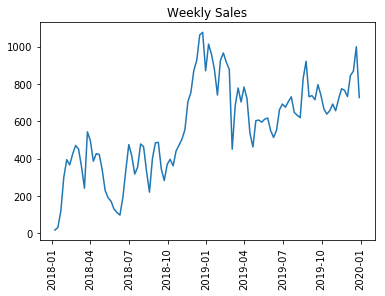

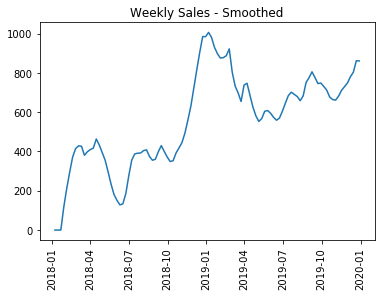

In [4]:

df_order_monthly = df_order_monthly.resample('M', on='date/time').sum()
df_order_weekly = df_order_weekly.resample('W', on='date/time').sum()
df_order_weekly.drop(df_order_weekly.tail(1).index,inplace=True) # drop last rows
df_refund_monthly = df_refund_monthly.resample('M', on='date/time').sum()
df_refund_weekly = df_refund_weekly.resample('W', on='date/time').sum()
df_refund_weekly.drop(df_refund_weekly.tail(1).index,inplace=True) # drop last rows

plt.figure()
plt.title('Weekly Sales')
plt.plot(df_order_weekly['quantity'])
plt.xticks(rotation=90);

plt.figure()
plt.title('Weekly Sales - Smoothed')
df_order_weekly['quantity'] = df_order_weekly['quantity'].rolling(4).mean()
df_order_weekly.fillna(0, inplace =True)
plt.plot(df_order_weekly['quantity'])
plt.xticks(rotation=90);

Investigate whether refunds are significant

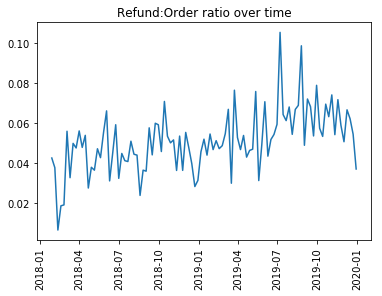

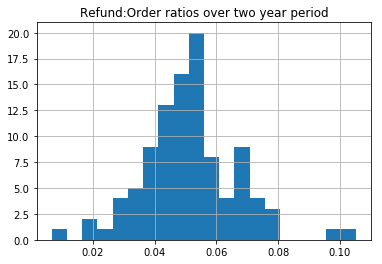

In [5]:
plt.figure()
plt.title('Refund:Order ratio over time')
plt.xticks(rotation=90);
plt.plot(df_refund_weekly['quantity']/df_order_weekly['quantity'])

plt.figure()
plt.title('Refund:Order ratios over two year period')
(df_refund_weekly['quantity']/df_order_weekly['quantity']).hist(bins=20)

About 5% of orders are refunded increasing slightly to 6% over two years. The refunds are normally distributed (bell shaped curve). This means we do not need to forecast refunds and orders separately, it is sufficient to forecast orders and assume that refunds will be at approxiately 5%.

## Forecast model # 1: ARIMA

ARIMA is a statistical model that calculates the correlation between sales on one week/month with sales in previous weeks/months. It uses this information to calculate the most probable number of sales in future weeks/months.

Below the model is fit to the monthly order data and a prediction is made and compared to actual data.

In [6]:
mod = sm.tsa.statespace.SARIMAX(df_order_monthly['quantity'],order=(4, 0, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

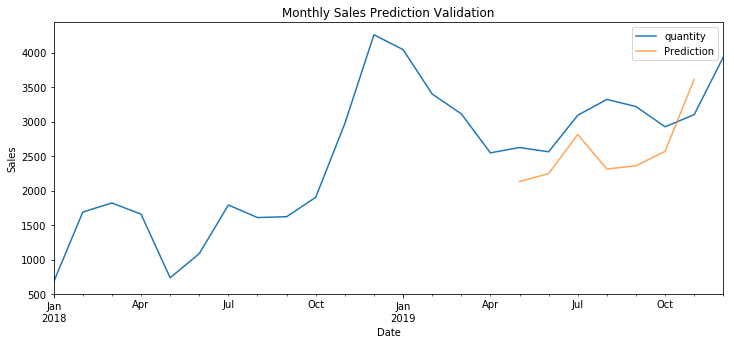

Sales over 6 month period: 20839
Predicted sales over 6 month period: 18042.0
Percent difference: -13.422%


In [18]:
predperiod = 6
start = 16
end = start+predperiod

pred = results.get_prediction(start=start, end=end,dynamic=True) #check
pred_ci = pred.conf_int()
ax = df_order_monthly.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(12, 5))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.title('Monthly Sales Prediction Validation')
plt.show()

total = df_order_monthly['quantity'].iloc[start:end+1].sum()
predtotal = round(pred.predicted_mean.sum())

print('Sales over ' +str(predperiod) +' month period: ' + str(total))
print('Predicted sales over ' +str(predperiod) +' month period: ' + str(predtotal))
print('Percent difference: ' + str(np.round(100*(predtotal-total)/total,3))+'%')

The algorithm above shows the difference between one 6 month sale period and one predicted sale period. To get a better idea of what results we might expect from this model, I calculate the average error for six 6-month sales periods (Jan-June, Feb-July, Mar-Aug, etc)

In [8]:
predperiod = 6
start = 13
end = start+predperiod
sum = 0
numperiods = 24-(start+predperiod)
for i in range(numperiods):
    pred = results.get_prediction(start=start+i, end=end+i,dynamic=True) #check
    total = df_order_monthly['quantity'].iloc[start:end+1].sum()
    predtotal = round(pred.predicted_mean.sum())
    sum = sum+ np.abs(predtotal-total)/total
    
print('Average error over all time periods= ' + str(100*np.round(sum/numperiods,3))+'%')

Average error over all time periods= 8.5%


The model can describe the data to about 91.5% accuracy! However, we can also try the same model on the noiser weekly data set. This is done below

In [9]:
mod2 = sm.tsa.statespace.SARIMAX(df_order_weekly['quantity'],order=(8, 1, 8),seasonal_order=(0,1, 0, 44), enforce_stationarity=True,mle_regression = False, time_varying_regression=True)
results_week = mod2.fit()

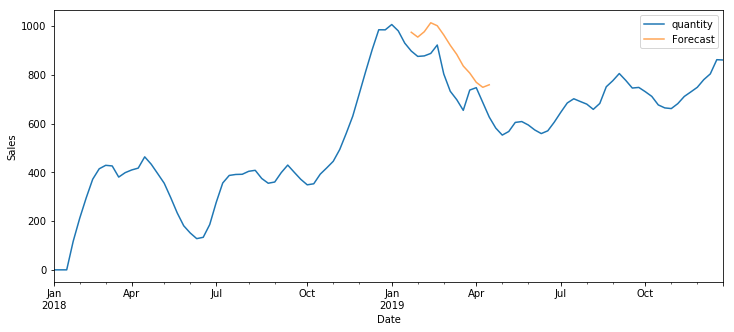

Sales over 12 week period: 10146.75
Predicted sales over 12 week period: 11609.0
Percent difference: 7.079


In [10]:
predperiod = 12
start = 55
end = start+predperiod

pred_week = results_week.get_prediction(start=start, end = end, dynamic=True) #check
pred_ci = pred_week.conf_int()
ax = df_order_weekly.plot(label='observed')
pred_week.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(12, 5))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

total_week = df_order_weekly['quantity'].iloc[start:end+1].sum()
predtotal_week = round(pred_week.predicted_mean.sum())

print('Sales over ' +str(predperiod) +' week period: ' + str(total_week))
print('Predicted sales over ' +str(predperiod) +' week period: ' + str(predtotal_week))
print('Percent difference: ' + str(np.round(100*(predtotal_week-total_week)/total,3)))

In [11]:
predperiod = 12
start = 53
end = start+predperiod
sum = 0
numperiods = 105-(start+predperiod)
for i in range(numperiods):
    pred_week = results_week.get_prediction(start=start+i, end=end+i,dynamic=True) #check
    total = df_order_weekly['quantity'].iloc[start:end+1].sum()
    predtotal = round(pred_week.predicted_mean.sum())
    sum = sum+ np.abs(predtotal-total)/total
    
print('Average error over all time periods= ' + str(100*np.round(sum/numperiods,3))+'%')

Average error over all time periods= 15.0%


Due to the noise in data the model does not perform as well but still may be useful for predicting general trends in the short term.

Now to forecast sales for the future:

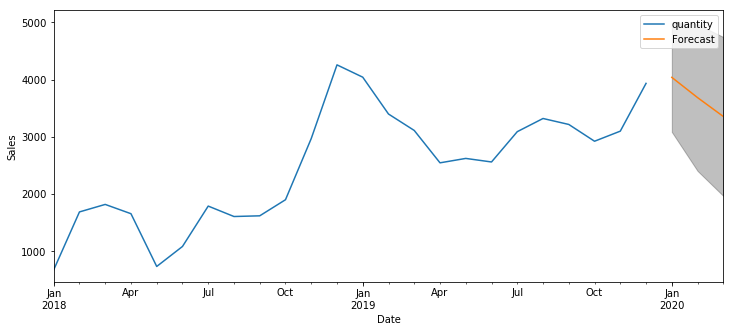

Total predicted sales in 6 months= 11081.0


In [19]:
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = df_order_monthly.plot(label='observed', figsize=(12, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

predtotal = round(pred_uc.predicted_mean.sum())
print('Total predicted sales in 6 months= ' + str(predtotal))

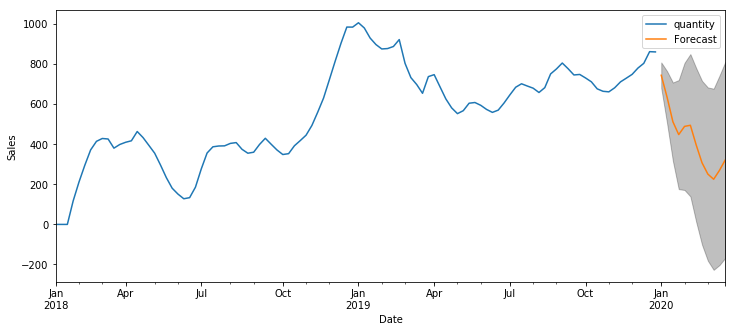

Total predicted sales in 12 weeks = 5095.0


In [13]:
pred_uc = results_week.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = df_order_weekly.plot(label='observed', figsize=(12, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

predtotal = round(pred_uc.predicted_mean.sum())
print('Total predicted sales in 12 weeks = ' + str(predtotal))

Both the monthly and weekly models predict a drop in sales for January 2020.

As an exercise we can also test our forecast model on refunds:

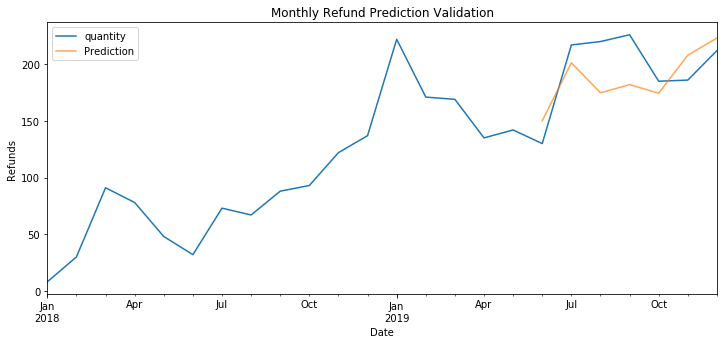

Refunds over 6 month period: 1376
Predicted refunds over 6 month period: 1314.0
Percent difference: -4.5%


In [14]:
mod_ref = sm.tsa.statespace.SARIMAX(df_refund_monthly['quantity'],order=(4, 0, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results_ref = mod_ref.fit()

predperiod = 6
start = 17
end = start+predperiod

pred = results_ref.get_prediction(start=start, end=end,dynamic=True) #check
pred_ci = pred.conf_int()
ax = df_refund_monthly.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(12, 5))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Refunds')
plt.legend()
plt.title('Monthly Refund Prediction Validation')
plt.show()

total = df_refund_monthly['quantity'].iloc[start:end+1].sum()
predtotal = round(pred.predicted_mean.sum())

print('Refunds over ' +str(predperiod) +' month period: ' + str(total))
print('Predicted refunds over ' +str(predperiod) +' month period: ' + str(predtotal))
print('Percent difference: ' + str(100*np.round((predtotal-total)/total,3))+'%')

The refund data is also well described by the monthly ARIMA model as expected.

## Random Forest Forecasting

A random forest is a machine learning model that builds decision trees to calculate the number of sales on a given week/month based on previous data.

I feed the model a lag of 10 weeks as well a linear fit to the sales data. I evaluate the model accuracy similarly to the ARIMA method above.

Sales over 12 week period: 8892.0
Predicted sales over 12 week period: 8560.0
Percent difference: -3.6999999999999997%


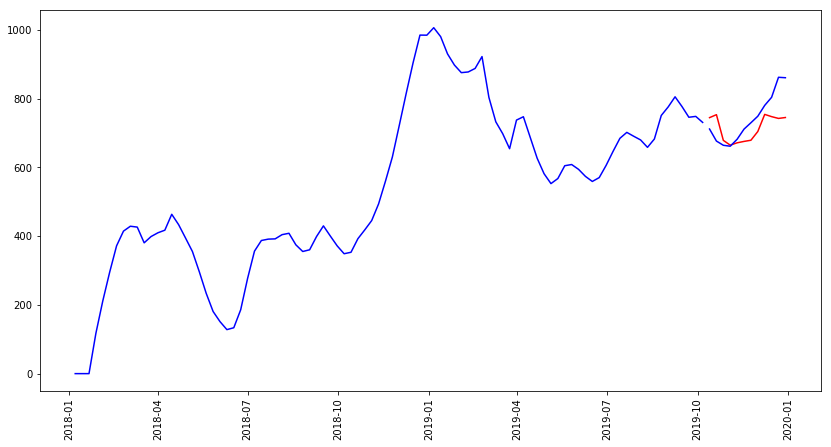

In [15]:
dfr = df_order_weekly
for i in range(10): #was 20
    dfr['lag'+str(i+1)] = dfr['quantity'].diff(i+1)
dfr=dfr.fillna(0)
#dfr['linear'] = 0
dfr['count'] = range(0,104)
dfr['linear'] = dfr.apply(lambda x: 200+7*x['count'] , axis = 1)
dfr = dfr.drop('count',axis=1)
#dfr = dfr.drop('roll',axis=1)

from sklearn.ensemble import RandomForestRegressor
#from skgarden import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
mean_error = []
mdl = []
mdl = RandomForestRegressor(max_depth = 15, n_estimators=100, n_jobs=-1, random_state=0)
trainidx = 92 #Number of weeks to include in the training set
predperiod = 12 #Number of weeks to predict

for i in range(trainidx,trainidx+1): #Can change second index if more training is required but I found this to work well
    train = pd.DataFrame(dfr.iloc[:i],index = dfr.iloc[:i].index,columns = dfr.columns)
    val = pd.DataFrame(dfr.iloc[i:i+predperiod],index = dfr.iloc[i:i+predperiod].index, columns = dfr.columns)
    
    xtr, xts = train.drop('quantity',axis=1), val.drop('quantity',axis=1) #Create training and test data
    ytr, yts = train['quantity'].values, val['quantity'].values #Labels for past and future values
    
mdl.fit(xtr.iloc[:trainidx],ytr)

r = []
r.append(mdl.predict([xts.iloc[0]])[0]) #first prediction

runningpred = pd.DataFrame(columns = xts.columns)
runningpred = runningpred.append(xts.iloc[0])
runningpred['linear'] = xts['linear'].iloc[0+1]
for i in range(1,11):
    runningpred['lag'+str(i)] = mdl.predict([xts.iloc[0]])[0]-ytr[-i]
    
for i in range(1,12):
    #runningpred['linear'] += 7
    for j in range(1,11):
        if i-j>=0:
            runningpred['lag'+str(j)] = mdl.predict([xts.iloc[i]])[0]-yts[i-j]
        if i-j<0:
            runningpred['lag'+str(j)] = mdl.predict([xts.iloc[i]])[0]-ytr[i-j]
    
    r.append(mdl.predict(runningpred)[0])

plt.figure(figsize=(14,7))
plt.plot(xts.index,r,'r')
plt.plot(xtr.index,ytr,'b')
plt.plot(xts.index,yts,'b')
plt.xticks(rotation=90);

total = df_order_weekly['quantity'].iloc[trainidx:trainidx+predperiod].sum()
predtotal = round(np.sum(r))

print('Sales over ' +str(predperiod) +' week period: ' + str(total))
print('Predicted sales over ' +str(predperiod) +' week period: ' + str(predtotal))
print('Percent difference: ' + str(100*np.round((predtotal-total)/total,3))+'%')

Finally, the prediction for future sales:

Predicted sales over 12 week period: 9412.0


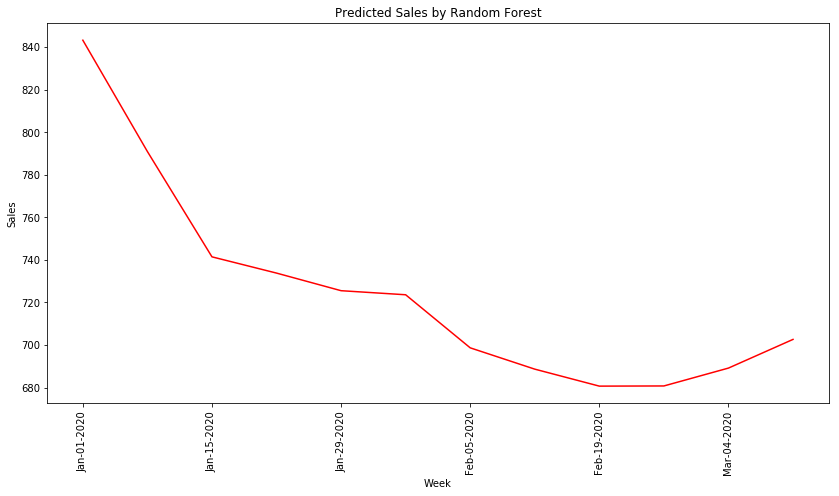

In [16]:
trainidx = 104 #Number of weeks to include in the training set
predperiod = 12 #Number of weeks to predict

for i in range(trainidx,trainidx+1): #Can change second index if more training is required but I found this to work well
    train = pd.DataFrame(dfr.iloc[:i],index = dfr.iloc[:i].index,columns = dfr.columns)
    val = pd.DataFrame(dfr.iloc[i:i+predperiod],index = dfr.iloc[i:i+predperiod].index, columns = dfr.columns)
    
    xtr, xts = train.drop('quantity',axis=1), val.drop('quantity',axis=1) #Create training and test data
    ytr, yts = train['quantity'].values, val['quantity'].values #Labels for past and future values
    
mdl.fit(xtr.iloc[:trainidx],ytr)

r = []
r.append(mdl.predict([xtr.iloc[-1]])[0]) #first prediction

runningpred = pd.DataFrame(columns = xts.columns)
runningpred = runningpred.append(xtr.iloc[-1])
#runningpred['linear'] = 1000
for i in range(1,11):
    runningpred['lag'+str(i)] = mdl.predict([xtr.iloc[-1]])[0]-ytr[-i]
    
for i in range(1,12):
    runningpred['linear'] += 7
    r.append(mdl.predict(runningpred)[0])
    for j in range(1,11):
        if i-j>=0:
            runningpred['lag'+str(j)] = r[-1]-r[i-j]
        if i-j<0:
            runningpred['lag'+str(j)] = r[-1]-ytr[i-j]
    
    

plt.figure(figsize=(14,7))
plt.title('Predicted Sales by Random Forest')
plt.plot(r,'r')
plt.xticks([0, 2, 4, 6, 8, 10],['Jan-01-2020','Jan-15-2020','Jan-29-2020','Feb-05-2020','Feb-19-2020','Mar-04-2020'],rotation=90);
plt.xlabel('Week')
plt.ylabel('Sales')
r.append(mdl.predict(runningpred)[0])

predtotal = round(np.sum(r))
print('Predicted sales over ' +str(predperiod) +' week period: ' + str(predtotal))